# Credit Card Prediction

## Introduction
In this notebook, we aim to build a machine learning model to predict whether a credit card applicant is a 'good' or 'bad' client. The dataset contains various attributes related to the applicant's personal information, employment, and credit history. The challenge in this task lies in the ambiguity of the definition of 'good' or 'bad' client, as well as the unbalanced nature of the data, which requires techniques like vintage analysis for constructing labels.

### Problem Context
Credit scoring plays a critical role in the financial industry, helping banks assess the risk associated with issuing credit cards to applicants. Traditionally, logistic regression models have been used for this task, but with the advent of more sophisticated machine learning algorithms such as Boosting, Random Forest, and Support Vector Machines (SVM), better predictive models have emerged. However, these newer models may lack transparency, making it harder to justify decisions to customers or regulators.

### Dataset Overview
The dataset consists of two main tables that can be merged by the `ID`:

1. **Application Record (`application_record.csv`)**: Contains personal and financial information about the applicants, such as income, family size, and employment history.
2. **Credit Record (`credit_record.csv`)**: Contains monthly records of applicants' credit payment statuses, where the status ranges from 0 (1-29 days overdue) to 5 (overdue for more than 150 days).

The objective is to construct a predictive model that can classify applicants as 'good' or 'bad' clients based on these features.

### Challenges
1. **Data Imbalance**: The dataset is likely to be imbalanced, with more 'good' clients than 'bad' ones. This can affect the performance of traditional machine learning algorithms.
2. **Label Construction**: The definition of 'good' or 'bad' client is not provided explicitly. We need to derive this label using techniques like vintage analysis.
3. **Feature Engineering**: Features need to be carefully processed, especially those related to the applicants' credit history, to make them useful for the predictive model.

### Approach
In this notebook, we will:
1. Load and inspect the dataset.
2. Perform necessary data preprocessing, including handling missing values, encoding categorical variables, and feature engineering.
3. Address the class imbalance problem using techniques like oversampling or undersampling.
4. Build and train multiple machine learning models, including logistic regression, decision trees, and ensemble methods.
5. Evaluate the models using appropriate metrics, such as accuracy, precision, recall, and F1-score.

Let’s begin by exploring the dataset and performing the initial preprocessing steps.


## Importing Libraries


In [ ]:
import pandas as pd  
import numpy as np  
import seaborn as sns  
import matplotlib.pyplot as plt  
import warnings  # To handle and suppress warnings in the code
from sklearn.utils import resample  # For data manipulation (e.g., resampling)

# Ignore warnings to avoid cluttering the output with unnecessary messages
warnings.filterwarnings("ignore")


## Loading the Datasets

In [2]:
# Load the dataset for application records into a pandas DataFrame
app = pd.read_csv('Data/application_record.csv')

# Load the dataset for credit records into a pandas DataFrame
credit = pd.read_csv('Data/credit_record.csv')


### Helper function

In [3]:
def bar_plot(df, column):
    # Create a count plot (bar plot) for the specified column in the DataFrame
    sns.countplot(data=df, x=column)
    
    # Add the x-axis label with the column name
    plt.xlabel(column)
    
    # Add the y-axis label with 'Count'
    plt.ylabel("Count")
    
    # Display the plot
    plt.show()


## Exploring the Datasets

In [4]:
app.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [7]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


## Merging the Datasets
Merging the `application_record` and `credit_record` datasets based on the `ID` column to create a unified dataset containing all the features for each client.


In [8]:
# Group the 'credit' DataFrame by the 'ID' column and calculate the minimum 'MONTHS_BALANCE' for each group
begin_month = pd.DataFrame(credit.groupby(["ID"])["MONTHS_BALANCE"].agg(min))


In [9]:
# Rename the 'MONTHS_BALANCE' column to 'first_month' in the 'begin_month' DataFrame
begin_month = begin_month.rename(columns={'MONTHS_BALANCE': 'first_month'})


In [10]:
# Merge the 'app' DataFrame with the 'begin_month' DataFrame on the 'ID' column
# Perform a left join to keep all rows from 'app' and match rows from 'begin_month'
data = pd.merge(app, begin_month, how="left", on="ID")


In [11]:
app.shape

(438557, 18)


## Data Cleanin & Preprocessing

Preparing the data for machine learning models by handling missing values, dropping unnecessary columns, and transforming the data into a consistent format.


In [12]:
credit['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

In [13]:
# Replace 'C' and 'X' values in the 'STATUS' column with 0 (missing or inactive status)
credit['STATUS'].replace({'C': 0, 'X': 0}, inplace=True)
# Convert the 'STATUS' column to integer type
credit['STATUS'] = credit['STATUS'].astype('int')
# Apply a lambda function to convert any positive value in 'STATUS' to 1, and 0 otherwise
credit['STATUS'] = credit['STATUS'].apply(lambda x: 1 if x > 0 else 0)


In [14]:
# Drop the 'MONTHS_BALANCE' column from the 'credit' DataFrame
df = credit.drop('MONTHS_BALANCE', axis=1)

# Merge the 'data' DataFrame with the modified 'df' DataFrame on the 'ID' column
# Perform a left join to keep all rows from 'data' and match rows from 'df'
data = pd.merge(data, df, how="left", on="ID")


In [15]:
# Check for missing (null) values in the 'data' DataFrame and sum them for each column
data.isnull().sum()


ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        362928
CNT_FAM_MEMBERS             0
first_month            402100
STATUS                 402100
dtype: int64

In [16]:
# Drop the 'OCCUPATION_TYPE' column from the 'data' DataFrame due to missing values
data.drop(columns=["OCCUPATION_TYPE"], inplace=True)

In [17]:
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,first_month,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-15.0,0.0
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-15.0,0.0
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-15.0,0.0
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-15.0,0.0
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-15.0,0.0


In [18]:
data.dropna(inplace = True)


In [19]:
data.drop("ID" , axis = 1 , inplace = True)


### Exploring Categorical Variables

Examining the distribution of categorical variables such as `CODE_GENDER`, `FLAG_OWN_CAR`, and `NAME_INCOME_TYPE` to understand their frequencies and potential impact on the model.


In [20]:
data["CODE_GENDER"].value_counts()

CODE_GENDER
F    518851
M    258864
Name: count, dtype: int64

In [21]:
data["CODE_GENDER"].describe()

count     777715
unique         2
top            F
freq      518851
Name: CODE_GENDER, dtype: object

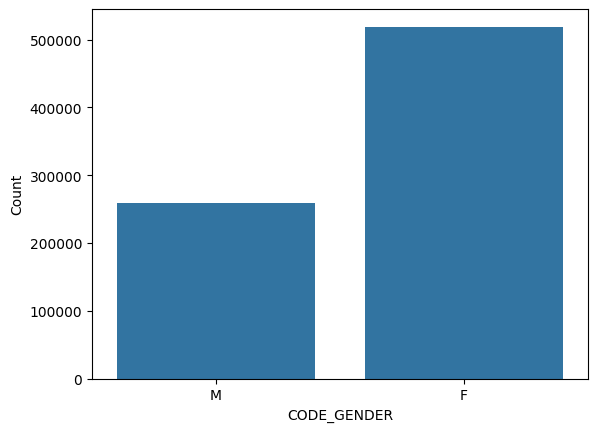

In [22]:
bar_plot(data , "CODE_GENDER")

In [23]:
data["FLAG_OWN_CAR"].value_counts()

FLAG_OWN_CAR
N    473355
Y    304360
Name: count, dtype: int64

In [24]:
data["FLAG_OWN_REALTY"].value_counts()

FLAG_OWN_REALTY
Y    512948
N    264767
Name: count, dtype: int64

In [25]:
data["FLAG_OWN_REALTY"].describe()

count     777715
unique         2
top            Y
freq      512948
Name: FLAG_OWN_REALTY, dtype: object

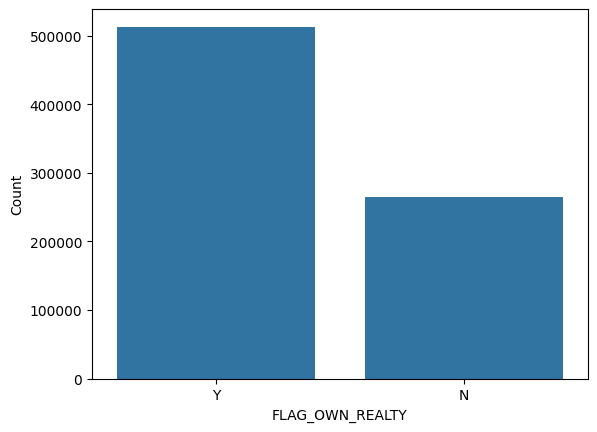

In [26]:
bar_plot(data , "FLAG_OWN_REALTY")

In [27]:
data["CNT_CHILDREN"].value_counts()

CNT_CHILDREN
0     540639
1     155638
2      70399
3       9328
4       1224
5        324
14       111
7         46
19         6
Name: count, dtype: int64

In [28]:
data["CNT_CHILDREN"].describe()

count    777715.000000
mean          0.428082
std           0.745755
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64

In [29]:
# Replace values in the 'CNT_CHILDREN' column that are greater than 3 with 3
data.loc[data["CNT_CHILDREN"] > 3, "CNT_CHILDREN"] = 3

# Check the count of unique values in the 'CNT_CHILDREN' column
data["CNT_CHILDREN"].value_counts()


CNT_CHILDREN
0    540639
1    155638
2     70399
3     11039
Name: count, dtype: int64

In [30]:
data["AMT_INCOME_TOTAL"].describe()

count    7.777150e+05
mean     1.885348e+05
std      1.016225e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.620000e+05
75%      2.250000e+05
max      1.575000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

### Data Normalization and Outlier Removal
Normalizing numerical features using Min-Max Scaling and removing outliers from the `AMT_INCOME_TOTAL` column to ensure that the model is not biased by extreme values.


<Axes: xlabel='AMT_INCOME_TOTAL'>

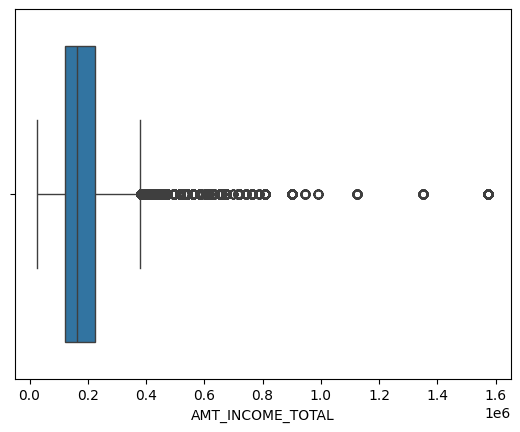

In [31]:
sns.boxplot(data = data , x=data["AMT_INCOME_TOTAL"] )

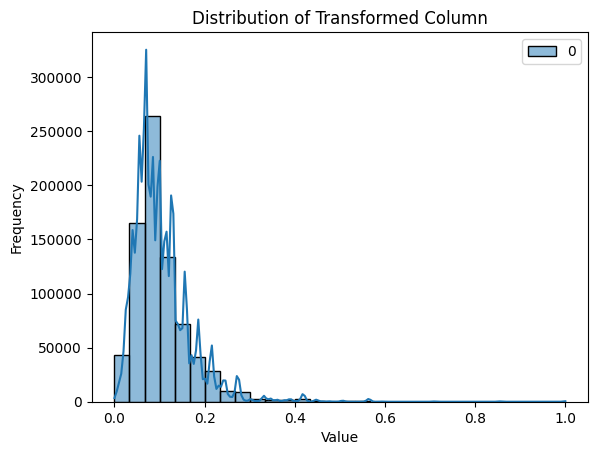

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the 'AMT_INCOME_TOTAL' column to scale it between 0 and 1
normalized_column = scaler.fit_transform(data[["AMT_INCOME_TOTAL"]])

# Create a histogram with a Kernel Density Estimate (KDE) to show the distribution of the normalized column
sns.histplot(normalized_column, kde=True, bins=30)

# Add a title and labels to the plot
plt.title("Distribution of Transformed Column")
plt.xlabel("Value")
plt.ylabel("Frequency")

# Show the plot
plt.show()


count    766887.000000
mean     181818.684887
std       82502.057119
min       27000.000000
25%      121500.000000
50%      157500.000000
75%      225000.000000
max      472500.000000
Name: AMT_INCOME_TOTAL, dtype: float64


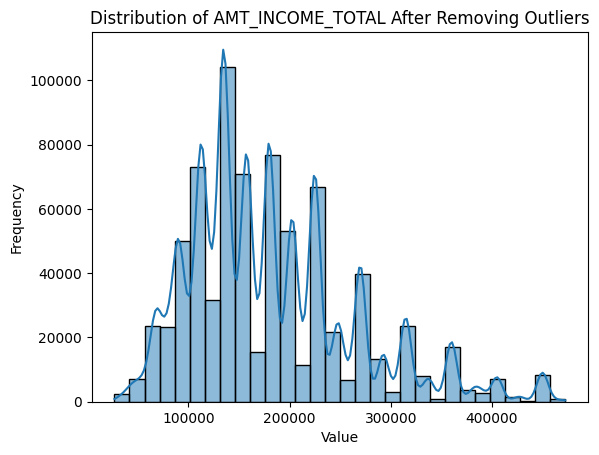

In [33]:
# Step 1: Save the original 'AMT_INCOME_TOTAL' column in a new column
data["AMT_INCOME_TOTAL_ORIGINAL"] = data["AMT_INCOME_TOTAL"]

# Step 2: Normalize the 'AMT_INCOME_TOTAL' column using MinMaxScaler
scaler = MinMaxScaler()
data["AMT_INCOME_TOTAL_NORMALIZED"] = scaler.fit_transform(data[["AMT_INCOME_TOTAL"]])

# Step 3: Remove rows where the normalized 'AMT_INCOME_TOTAL' is greater than 0.3
data = data[data["AMT_INCOME_TOTAL_NORMALIZED"] <= 0.3].reset_index(drop=True)

# Step 4: Restore the original 'AMT_INCOME_TOTAL' column
data["AMT_INCOME_TOTAL"] = data["AMT_INCOME_TOTAL_ORIGINAL"]

# Step 5: Drop the normalized columns to clean the data
data.drop(columns=["AMT_INCOME_TOTAL_NORMALIZED", "AMT_INCOME_TOTAL_ORIGINAL"], inplace=True)

# Step 6: Print the descriptive statistics for the 'AMT_INCOME_TOTAL' column
print(data["AMT_INCOME_TOTAL"].describe())

# Step 7: Plot the distribution of 'AMT_INCOME_TOTAL' after removing outliers
sns.histplot(data["AMT_INCOME_TOTAL"], kde=True, bins=30)
plt.title("Distribution of AMT_INCOME_TOTAL After Removing Outliers")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [34]:
data["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Working                 396095
Commercial associate    178085
Pensioner               127886
State servant            64484
Student                    337
Name: count, dtype: int64

In [35]:
# Filter out rows where the 'NAME_INCOME_TYPE' is 'Pensioner' or 'Student'
data = data[~data["NAME_INCOME_TYPE"].isin(["Pensioner", "Student"])].reset_index(drop=True)

# Display the value counts for the 'NAME_INCOME_TYPE' column after filtering
print(data["NAME_INCOME_TYPE"].value_counts())


NAME_INCOME_TYPE
Working                 396095
Commercial associate    178085
State servant            64484
Name: count, dtype: int64


In [36]:
data["NAME_EDUCATION_TYPE"].value_counts()

NAME_EDUCATION_TYPE
Secondary / secondary special    419468
Higher education                 184876
Incomplete higher                 28314
Lower secondary                    5187
Academic degree                     819
Name: count, dtype: int64

In [37]:
# Define a mapping of old education types to new categories
education_mapping = {
    "Higher education": "University education / complete",
    "Incomplete higher": "University education / complete",
    "Academic degree": "University education / complete",
    "Secondary / secondary special": "Pre-university education",
    "Lower secondary": "Pre-university education"
}

# Replace the values in the 'NAME_EDUCATION_TYPE' column based on the mapping
data["NAME_EDUCATION_TYPE"] = data["NAME_EDUCATION_TYPE"].replace(education_mapping)

# Display the value counts for the 'NAME_EDUCATION_TYPE' column after replacement
print(data["NAME_EDUCATION_TYPE"].value_counts())


NAME_EDUCATION_TYPE
Pre-university education           424655
University education / complete    214009
Name: count, dtype: int64


In [38]:
data["NAME_HOUSING_TYPE"].value_counts()

NAME_HOUSING_TYPE
House / apartment      564151
With parents            35154
Municipal apartment     20918
Rented apartment        10128
Office apartment         4847
Co-op apartment          3466
Name: count, dtype: int64

In [39]:
data["DAYS_BIRTH"].describe()

count    638664.000000
mean     -14987.132522
std        3443.411137
min      -24611.000000
25%      -17615.000000
50%      -14768.000000
75%      -12175.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

<Axes: xlabel='DAYS_BIRTH'>

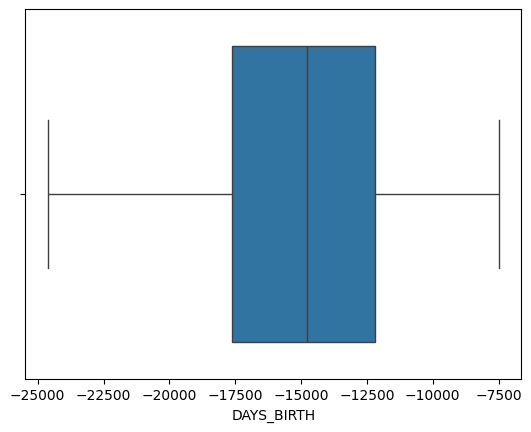

In [40]:
sns.boxplot(data = data , x=data["DAYS_BIRTH"] )

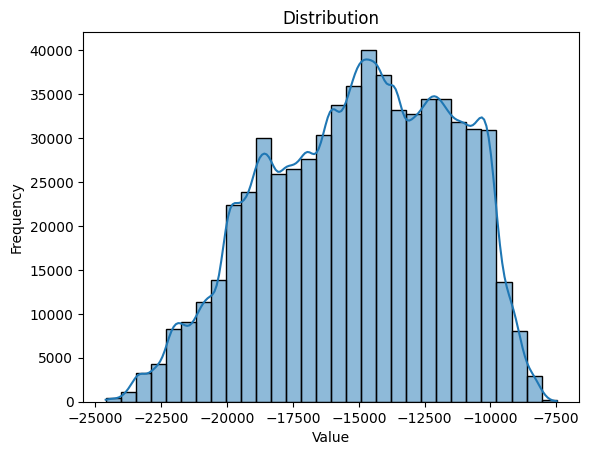

In [41]:
sns.histplot(data["DAYS_BIRTH"], kde=True, bins=30)
plt.title("Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [42]:
data["DAYS_EMPLOYED"].describe()

count    638664.000000
mean      -2783.301775
std        2426.475842
min      -15713.000000
25%       -3668.000000
50%       -2170.000000
75%       -1048.000000
max         -17.000000
Name: DAYS_EMPLOYED, dtype: float64

<Axes: xlabel='DAYS_EMPLOYED'>

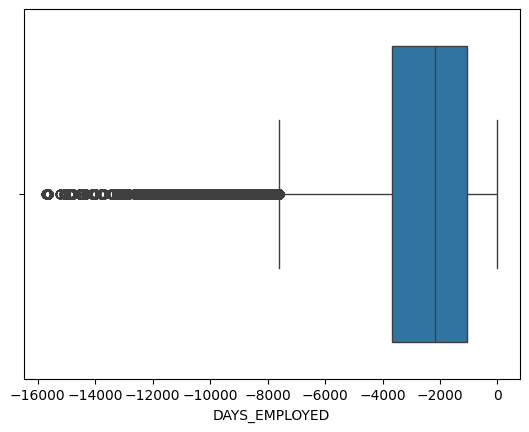

In [43]:
sns.boxplot(data = data , x=data["DAYS_EMPLOYED"] )

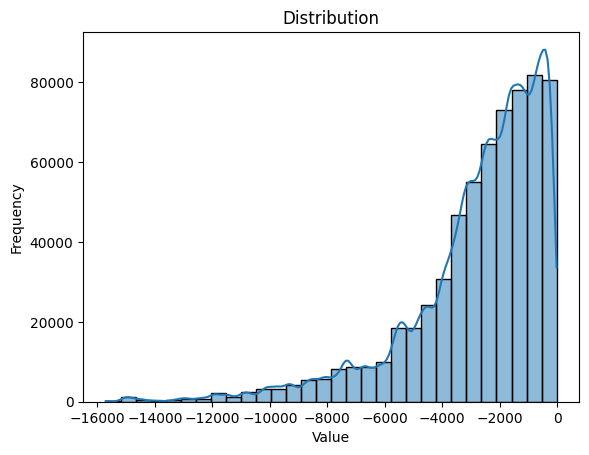

In [44]:
sns.histplot(data["DAYS_EMPLOYED"], kde=True, bins=30)
plt.title("Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

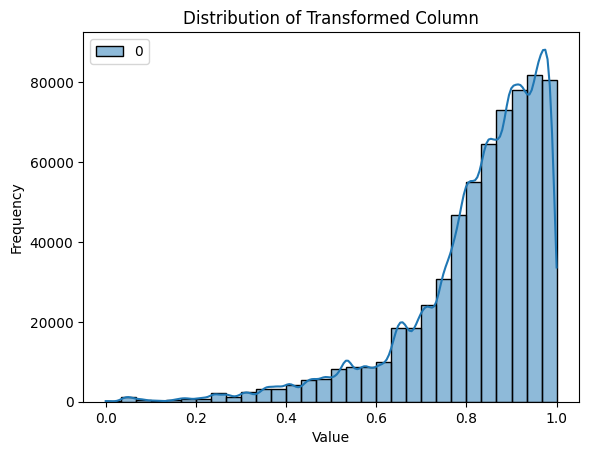

In [45]:
normalized_column = scaler.fit_transform(data[["DAYS_EMPLOYED"]])


sns.histplot(normalized_column, kde=True, bins=30)
plt.title("Distribution of Transformed Column")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

count    622482.000000
mean      -2560.500554
std        2003.334315
min       -9422.000000
25%       -3506.000000
50%       -2092.000000
75%       -1018.000000
max         -17.000000
Name: DAYS_EMPLOYED, dtype: float64


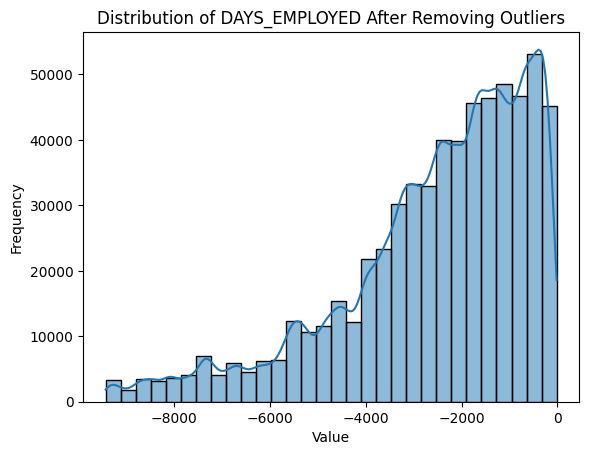

In [46]:
# Save the original 'DAYS_EMPLOYED' column as a backup
data["DAYS_EMPLOYED_ORIGINAL"] = data["DAYS_EMPLOYED"]

# Normalize the 'DAYS_EMPLOYED' column using MinMaxScaler
scaler = MinMaxScaler()
data["DAYS_EMPLOYED_NORMALIZED"] = scaler.fit_transform(data[["DAYS_EMPLOYED"]])

# Filter out rows where the normalized 'DAYS_EMPLOYED' is less than 0.4
data = data[data["DAYS_EMPLOYED_NORMALIZED"] >= 0.4].reset_index(drop=True)

# Restore the original 'DAYS_EMPLOYED' column
data["DAYS_EMPLOYED"] = data["DAYS_EMPLOYED_ORIGINAL"]

# Drop the temporary normalized columns
data.drop(columns=["DAYS_EMPLOYED_NORMALIZED", "DAYS_EMPLOYED_ORIGINAL"], inplace=True)

# Display the descriptive statistics of the 'DAYS_EMPLOYED' column
print(data["DAYS_EMPLOYED"].describe())

# Plot the distribution of 'DAYS_EMPLOYED' after removing outliers
sns.histplot(data["DAYS_EMPLOYED"], kde=True, bins=30)
plt.title("Distribution of DAYS_EMPLOYED After Removing Outliers")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [47]:
data["FLAG_MOBIL"].value_counts()

FLAG_MOBIL
1    622482
Name: count, dtype: int64

In [48]:
data = data.drop(columns=["FLAG_MOBIL"])

In [49]:
data.drop(columns=["FLAG_EMAIL"] , inplace = True)

In [50]:
data["FLAG_WORK_PHONE"].value_counts()

FLAG_WORK_PHONE
0    448962
1    173520
Name: count, dtype: int64

In [51]:
data["CNT_FAM_MEMBERS"].value_counts()

CNT_FAM_MEMBERS
2.0     321949
3.0     128378
1.0      96631
4.0      65174
5.0       8724
6.0       1190
7.0        273
15.0       111
9.0         46
20.0         6
Name: count, dtype: int64

In [52]:
data = data[data["CNT_FAM_MEMBERS"] <= 4]

print(data["CNT_FAM_MEMBERS"].value_counts())

CNT_FAM_MEMBERS
2.0    321949
3.0    128378
1.0     96631
4.0     65174
Name: count, dtype: int64


In [53]:
data["first_month"].describe()

count    612132.000000
mean        -34.662395
std          15.009878
min         -60.000000
25%         -47.000000
50%         -36.000000
75%         -23.000000
max           0.000000
Name: first_month, dtype: float64

<Axes: xlabel='first_month'>

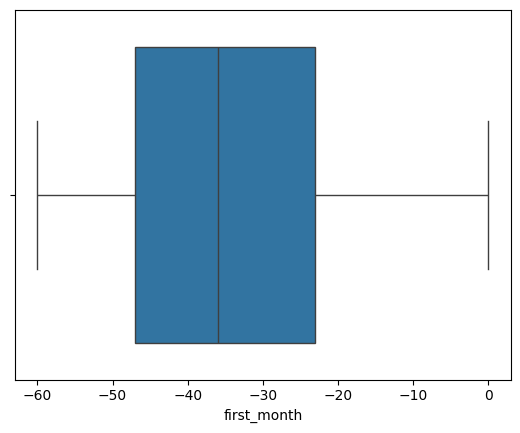

In [54]:
sns.boxplot(data = data , x=data["first_month"] )

### Feature Engineering: Calculating Age and Years Employed

Creating new features such as `AGE_YEARS` and `YEARS_EMPLOYED` based on the existing `DAYS_BIRTH` and `DAYS_EMPLOYED` columns to provide additional useful information to the model.


In [55]:
# Calculate 'AGE_YEARS' by dividing 'DAYS_BIRTH' by -365 and rounding to 1 decimal place
data['AGE_YEARS'] = (data['DAYS_BIRTH'] / -365).round(1)  

# Calculate 'YEARS_EMPLOYED' by dividing 'DAYS_EMPLOYED' by -365 and rounding to 1 decimal place
data['YEARS_EMPLOYED'] = (data['DAYS_EMPLOYED'] / -365).round(1)

# Display the first few rows of 'AGE_YEARS' and 'YEARS_EMPLOYED' columns
data[['AGE_YEARS', 'YEARS_EMPLOYED']].head()


,AGE_YEARS,YEARS_EMPLOYED
0,32.9,12.4
1,32.9,12.4
2,32.9,12.4
3,32.9,12.4
4,32.9,12.4


In [56]:
data.drop(columns = ["DAYS_BIRTH" , "DAYS_EMPLOYED"] , axis = 1 , inplace = True)


In [57]:
data

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,first_month,STATUS,AGE_YEARS,YEARS_EMPLOYED
0,M,Y,Y,0,427500.0,Working,University education / complete,Civil marriage,Rented apartment,1,0,2.0,-15.0,0.0,32.9,12.4
1,M,Y,Y,0,427500.0,Working,University education / complete,Civil marriage,Rented apartment,1,0,2.0,-15.0,0.0,32.9,12.4
2,M,Y,Y,0,427500.0,Working,University education / complete,Civil marriage,Rented apartment,1,0,2.0,-15.0,0.0,32.9,12.4
3,M,Y,Y,0,427500.0,Working,University education / complete,Civil marriage,Rented apartment,1,0,2.0,-15.0,0.0,32.9,12.4
4,M,Y,Y,0,427500.0,Working,University education / complete,Civil marriage,Rented apartment,1,0,2.0,-15.0,0.0,32.9,12.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622477,M,N,Y,0,112500.0,Working,Pre-university education,Single / not married,Rented apartment,0,0,1.0,-13.0,0.0,25.2,3.3
622478,M,N,Y,0,112500.0,Working,Pre-university education,Single / not married,Rented apartment,0,0,1.0,-13.0,1.0,25.2,3.3
622479,M,N,Y,0,112500.0,Working,Pre-university education,Single / not married,Rented apartment,0,0,1.0,-13.0,1.0,25.2,3.3
622480,M,N,Y,0,112500.0,Working,Pre-university education,Single / not married,Rented apartment,0,0,1.0,-13.0,0.0,25.2,3.3


### Encoding Categorical Variables

Encoding categorical variables like `CODE_GENDER`, `FLAG_OWN_CAR`, `NAME_INCOME_TYPE`, etc., using Label Encoding so that they can be processed by machine learning algorithms.


In [58]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Define the list of categorical columns to encode
columns = ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
           "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", 
           "NAME_FAMILY_STATUS", "NAME_HOUSING_TYPE"]

# Create a copy of the data
data2 = data

# Loop through each column in the 'columns' list and apply LabelEncoder
for column in columns:
    # Encode the categorical column and update it in data2
    data2[column] = encoder.fit_transform(data[column])

# Display the transformed data
data2


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,first_month,STATUS,AGE_YEARS,YEARS_EMPLOYED
0,1,1,1,0,427500.0,2,1,0,4,1,0,2.0,-15.0,0.0,32.9,12.4
1,1,1,1,0,427500.0,2,1,0,4,1,0,2.0,-15.0,0.0,32.9,12.4
2,1,1,1,0,427500.0,2,1,0,4,1,0,2.0,-15.0,0.0,32.9,12.4
3,1,1,1,0,427500.0,2,1,0,4,1,0,2.0,-15.0,0.0,32.9,12.4
4,1,1,1,0,427500.0,2,1,0,4,1,0,2.0,-15.0,0.0,32.9,12.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622477,1,0,1,0,112500.0,2,0,3,4,0,0,1.0,-13.0,0.0,25.2,3.3
622478,1,0,1,0,112500.0,2,0,3,4,0,0,1.0,-13.0,1.0,25.2,3.3
622479,1,0,1,0,112500.0,2,0,3,4,0,0,1.0,-13.0,1.0,25.2,3.3
622480,1,0,1,0,112500.0,2,0,3,4,0,0,1.0,-13.0,0.0,25.2,3.3


### Normalizing Numerical Features
Scaling numerical features such as `AMT_INCOME_TOTAL` using Min-Max Scaling so that all features contribute equally to the model's performance.


In [59]:
from sklearn.preprocessing import MinMaxScaler

numerical_columns = data2.select_dtypes(include=['float64', 'int64']).columns


scaler = MinMaxScaler()

# Fit and transform the data
data2[numerical_columns] = scaler.fit_transform(data2[numerical_columns])

data2

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,CNT_FAM_MEMBERS,first_month,STATUS,AGE_YEARS,YEARS_EMPLOYED
0,1.0,1.0,1.0,0.0,0.898990,1.0,1.0,0.00,0.8,1.0,0.0,0.333333,0.750000,0.0,0.264392,0.480620
1,1.0,1.0,1.0,0.0,0.898990,1.0,1.0,0.00,0.8,1.0,0.0,0.333333,0.750000,0.0,0.264392,0.480620
2,1.0,1.0,1.0,0.0,0.898990,1.0,1.0,0.00,0.8,1.0,0.0,0.333333,0.750000,0.0,0.264392,0.480620
3,1.0,1.0,1.0,0.0,0.898990,1.0,1.0,0.00,0.8,1.0,0.0,0.333333,0.750000,0.0,0.264392,0.480620
4,1.0,1.0,1.0,0.0,0.898990,1.0,1.0,0.00,0.8,1.0,0.0,0.333333,0.750000,0.0,0.264392,0.480620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622477,1.0,0.0,1.0,0.0,0.191919,1.0,0.0,0.75,0.8,0.0,0.0,0.000000,0.783333,0.0,0.100213,0.127907
622478,1.0,0.0,1.0,0.0,0.191919,1.0,0.0,0.75,0.8,0.0,0.0,0.000000,0.783333,1.0,0.100213,0.127907
622479,1.0,0.0,1.0,0.0,0.191919,1.0,0.0,0.75,0.8,0.0,0.0,0.000000,0.783333,1.0,0.100213,0.127907
622480,1.0,0.0,1.0,0.0,0.191919,1.0,0.0,0.75,0.8,0.0,0.0,0.000000,0.783333,0.0,0.100213,0.127907


In [60]:
data2["STATUS"].value_counts()

STATUS
0.0    602934
1.0      9198
Name: count, dtype: int64

### Balancing the Class Distribution
Balancing the class distribution by upsampling the minority class and downsampling the majority class to address the class imbalance and improve model performance.


In [61]:

# Current distribution
total_samples = len(data2)  # Total number of rows in the original dataset
desired_ratio_majority = 0.5
desired_ratio_minority = 0.5

# Calculate the desired number of samples for each class
desired_majority_count = int(total_samples * desired_ratio_majority)
desired_minority_count = int(total_samples * desired_ratio_minority)

# Separate the dataset into majority and minority classes
majority_class = data2[data2["STATUS"] == 0.0]
minority_class = data2[data2["STATUS"] == 1.0]

# Resample majority and minority classes
majority_resampled = resample(
    majority_class,
    replace=False,  # Downsample the majority class
    n_samples=desired_majority_count,
    random_state=42
)

minority_resampled = resample(
    minority_class,
    replace=True,  # Upsample the minority class
    n_samples=desired_minority_count,
    random_state=42
)

# Combine the resampled datasets
data_balanced = pd.concat([majority_resampled, minority_resampled])

# Shuffle the dataset
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the new class distribution
print("Class Distribution After Balancing:")
print(data_balanced["STATUS"].value_counts(normalize=True))

Class Distribution After Balancing:
STATUS
1.0    0.5
0.0    0.5
Name: proportion, dtype: float64


In [62]:
data_balanced.drop(columns=['FLAG_WORK_PHONE','FLAG_PHONE','first_month'], inplace = True)

In [63]:
data_balanced

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,CNT_FAM_MEMBERS,STATUS,AGE_YEARS,YEARS_EMPLOYED
0,1.0,1.0,1.0,0.000000,0.393939,1.0,1.0,0.25,0.2,0.333333,1.0,0.590618,0.321705
1,0.0,1.0,1.0,0.000000,0.494949,0.0,0.0,0.25,0.2,0.333333,0.0,0.503198,0.472868
2,1.0,1.0,0.0,0.000000,0.444444,0.0,0.0,0.25,0.8,0.333333,0.0,0.191898,0.155039
3,0.0,0.0,0.0,0.000000,0.595960,0.0,1.0,0.25,0.2,0.333333,1.0,0.607676,0.093023
4,0.0,0.0,0.0,0.000000,0.141414,1.0,1.0,0.25,0.2,0.333333,1.0,0.287846,0.158915
...,...,...,...,...,...,...,...,...,...,...,...,...,...
612127,0.0,0.0,1.0,0.000000,0.595960,1.0,1.0,0.75,0.2,0.000000,0.0,0.456290,0.011628
612128,0.0,0.0,0.0,0.000000,0.242424,1.0,0.0,0.25,0.2,0.333333,0.0,0.385928,0.197674
612129,0.0,1.0,1.0,0.000000,0.777778,1.0,0.0,1.00,0.2,0.000000,1.0,0.776119,0.166667
612130,0.0,0.0,0.0,0.000000,0.414141,0.0,1.0,0.25,1.0,0.333333,0.0,0.417910,0.496124


### Visualizing Correlation Matrix
Creating a correlation matrix to visualize the relationships between the features and identify highly correlated variables that might need to be handled before modeling.


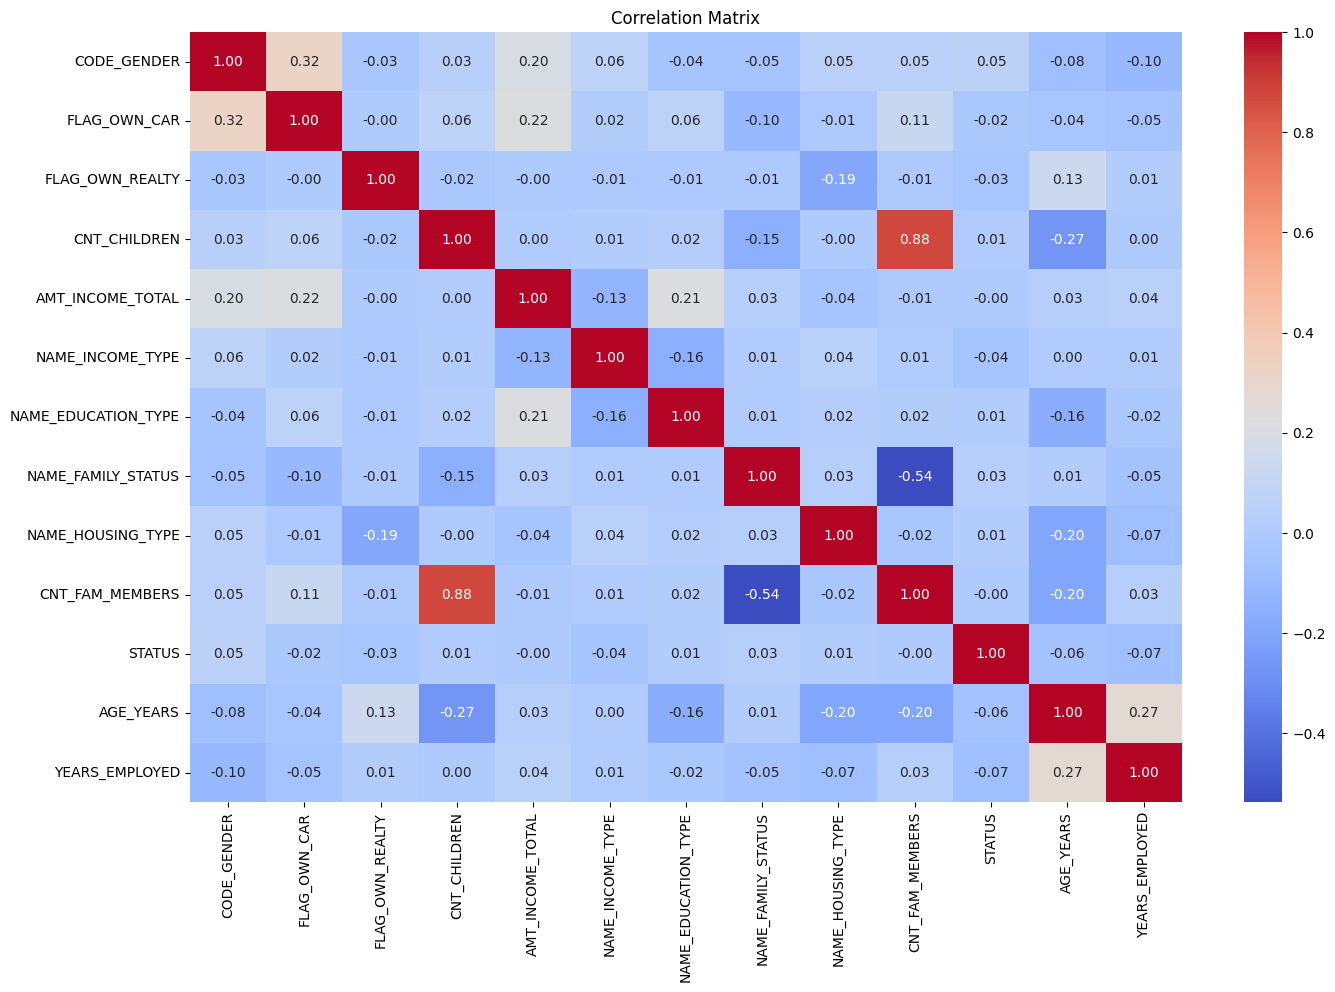

In [64]:
correlation_matrix = data_balanced.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix")
plt.show()


### Splitting the Data and Applying Principal Component Analysis (PCA)
Applying Principal Component Analysis (PCA) to reduce the dimensionality of the data and create new components that explain the majority of the variance in the dataset.


In [65]:
from sklearn.model_selection import  train_test_split
x = data_balanced.drop(columns=["STATUS"]  , axis = 1 )
y = data_balanced["STATUS"]


In [67]:
# Split Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [68]:
x_train

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,CNT_FAM_MEMBERS,AGE_YEARS,YEARS_EMPLOYED
484156,0.0,0.0,1.0,0.000000,0.232323,0.5,0.0,0.25,0.2,0.333333,0.302772,0.368217
198340,0.0,0.0,0.0,0.666667,0.343434,0.0,0.0,0.25,0.2,1.000000,0.426439,0.104651
84768,0.0,0.0,0.0,0.333333,0.292929,1.0,0.0,0.00,1.0,0.666667,0.245203,0.391473
80629,0.0,0.0,1.0,0.000000,0.747475,0.0,1.0,0.50,0.2,0.000000,0.611940,0.294574
399169,0.0,0.0,1.0,0.000000,0.141414,0.5,0.0,1.00,0.2,0.000000,0.594883,0.465116
...,...,...,...,...,...,...,...,...,...,...,...,...
110268,0.0,0.0,1.0,0.333333,0.343434,1.0,1.0,0.25,0.4,0.666667,0.191898,0.007752
259178,1.0,0.0,0.0,0.000000,0.343434,0.0,1.0,0.25,0.2,0.333333,0.217484,0.248062
365838,1.0,1.0,1.0,0.000000,0.696970,1.0,1.0,0.25,0.2,0.333333,0.948827,0.794574
131932,0.0,0.0,1.0,0.000000,0.141414,1.0,0.0,0.00,1.0,0.333333,0.402985,0.015504


In [69]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle

numerical_cols = ['AMT_INCOME_TOTAL','CNT_CHILDREN','CNT_FAM_MEMBERS','AGE_YEARS','YEARS_EMPLOYED']

categorical_cols = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE']


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

print("Preprocessor object created successfully!")


Preprocessor object created successfully!


## Data Modeling & Evaluation


In [71]:
# Random Forest Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the model with hyperparameters
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)  # Adjust hyperparameters

# Train the model
rf_model.fit(x_train, y_train)

# Make predictions on the test set
rf_predictions = rf_model.predict(x_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))


Random Forest Accuracy: 0.7981
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81     61263
         1.0       0.84      0.73      0.78     61164

    accuracy                           0.80    122427
   macro avg       0.80      0.80      0.80    122427
weighted avg       0.80      0.80      0.80    122427



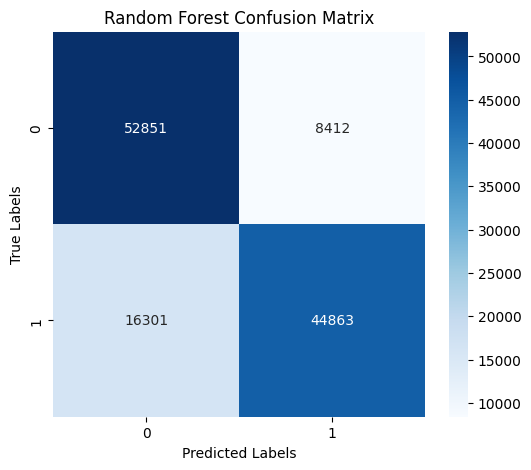

In [72]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix for the Random Forest model
rf_cm = confusion_matrix(y_test, rf_predictions)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [73]:
# XGBoost Model

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the model with hyperparameters
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)  # Adjust hyperparameters

# Train the model
xgb_model.fit(x_train, y_train)

# Make predictions on the test set
xgb_predictions = xgb_model.predict(x_test)

# Evaluate the model
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))


XGBoost Accuracy: 0.7493
XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75     61263
         1.0       0.76      0.73      0.74     61164

    accuracy                           0.75    122427
   macro avg       0.75      0.75      0.75    122427
weighted avg       0.75      0.75      0.75    122427



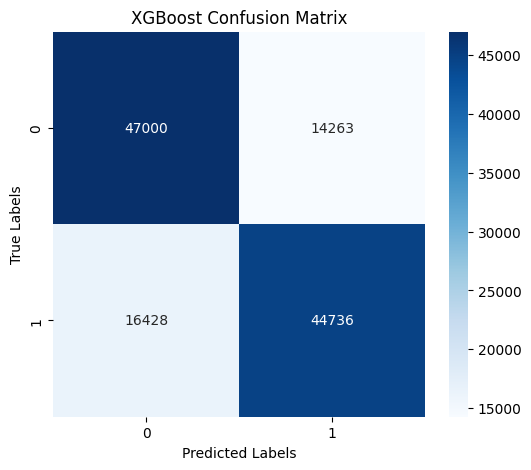

In [74]:
# Generate the confusion matrix for the XGBoost model
xgb_cm = confusion_matrix(y_test, xgb_predictions)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
final_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', rf_model)
])
final_pipeline.fit(x_train, y_train)
y_pred = final_pipeline.predict(x_test)


In [76]:
final_pipeline.predict_proba(x_train.head(1))
# print(final_pipeline)


array([[0.52803745, 0.47196255]])

In [77]:
import pickle
pickle.dump(final_pipeline, open(
    "credit_card_approval_pipeline.pkl", "wb"
))


# Conclusion

* Loaded and explored the application_record and credit_record datasets to understand applicant demographics and credit behavior.

* Cleaned the data by handling missing values, correcting data types, and selecting relevant features required for credit approval prediction.

* Created meaningful features such as AGE_YEARS and YEARS_EMPLOYED from raw data to improve model interpretability.

* Defined numerical and categorical features explicitly to avoid feature mismatch issues during deployment.

* Applied StandardScaler to numerical features and OneHotEncoder to categorical features using a ColumnTransformer.

* Integrated preprocessing and model training into a single scikit-learn Pipeline for consistency and reproducibility.

* Trained a RandomForestClassifier on the processed training data and evaluated its performance.

* Ensured the pipeline was fitted on raw input data, making it compatible with real-time user input.

* Serialized the entire trained pipeline (preprocessing + model) into a pickle file for deployment.

* Verified the saved pickle by testing predictions on sample raw input data before using it in a Flask web application.